# Benchmarking `SurrealML` vs `ONNX` vs `PyTorch` 

## Table of contents

1.  <a href="#1">General dependencies and helpers</a>
2.  <a href="#2">Some words about SurrealML</a>
3.  <a href="#3">Problem refinement</a>
4.  <a href="#4">A typical neural network</a>
5.  <a href="#5">Starting a SurrealDB instance</a>
6.  <a href="#6">Loading the model to SurrealDB</a>
7.  <a href="#7">Exporting the model to ONNX</a>
8.  <a href="#8">Generating and inserting fake data to SurrealDB</a>
9.  <a href="#9">Benchmarking `SurrealML` vs `ONNX` vs `PyTorch`</a>

<h2 id="1"></h2>

## General dependencies and helpers

We will start by exporting some tools we will use for timing, and operating with SurrealDB/SurrrealML...

In [1]:
import os
import time
from datetime import datetime
from functools import wraps
import numpy as np
from onnxruntime.capi.onnxruntime_inference_collection import InferenceSession

import torch
import torch.nn as nn

from surrealml import SurMlFile, Engine
from surrealist import Surreal
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.magic import register_cell_magic


def chronometer(foo):
    @wraps(foo)
    def wrapper(*args, **kwargs):
        start = time.time()
        output = foo(*args, **kwargs)
        end = time.time()
        return end - start, output

    return wrapper


@register_cell_magic
def skip(line, cell):
    return

<h2 id="2"></h2>

## Some words about SurrealML

According to the [official docs](https://surrealdb.com/docs/surrealml):
    
```text
SurrealML is an engine that seeks to do one thing, and one thing well: store and execute trained ML models. SurrealML does not intrude on the training frameworks that are already out there, instead works with them to ease the storage, loading, and execution of models. Someone using SurrealML will be able to train their model in a chosen framework in Python, save their model, and load and execute the model in either Python or Rust.
```

Basically, we aim to develop and train models using `PyTorch/scikit-learn/Tensorflow/linfa`, and then load them to SurrealDB.

Inside SurrealDB, a model is represented in the [.surml format](https://surrealdb.com/docs/surrealml/storage#the-anatomy-of-a-surml-file). Schematically, from top to bottom of a .surml file, we roughly have that:

`.surml file` =  `4 byte integer` + `variable metadata [size specified by 4 bytes integer]` + `model parameters [ONNX format]`

A .surml file is loaded by starting with the 4 bytes integer, and then using it to determine the length of the model metadata. Once the model metadata has been loaded, the loader assumes that the rest is ONNX protobuf, and parses it accordingly.

At the time of writing, in the [source code](https://github.com/surrealdb/surrealml/blob/main/surrealml/engine/__init__.py) of the `Engine` enum, we have the following docstring:

_Attributes_:
- **PYTORCH**: The PyTorch engine which will be PyTorch and ONNX.
- **NATIVE**: The native engine which will be native Rust and Linfa.
- **SKLEARN**: The scikit-learn engine which will be scikit-learn and ONNX.
- **TENSORFLOW**: The TensorFlow engine which will be TensorFlow and ONNX.
- **ONNX**: The ONNX engine which bypasses the conversion to ONNX.

Thus, we may infer that, for the sake of comparing `SurrealML` vs `ONNX` vs `PyTorch`, for the same model, it should be equivalent using `Engine.PYTORCH`/`Engine.SKLEARN`/`Engine.TENSORFLOW`, as irrespective of the framework used, the model will be exported to the ONNX first.

<a id="3"></a>

## Problem refinement

We single out three cases that may be encountered in practice, namely:

1. **Execute with SurrealML[inside SurrealDB] && fetch data from SurrealDB [optional]**: predicting with the model in .surml format _inside_ the SurrealDB, and then _optionally_ (here included) fetching the prediction from SurrealDB.
2. **Fetch data from SurrealDB && execute with PyTorch**: fetching the data from SurrealDB and _externally_ predicting with the PyTorch model.
3. **Fetch data from SurrealDB && execute with ONNX runtime**: fetching the data from SurrealDB and _externally_ predicting with the ONNX model.

Given the 3 scenarios above, one may deduct the following benefits of using SurrealML:

- **Reduced Database Transactions**
  - No need to fetch data from SurrealDB if predictions are not consumed immediately.
  - Eliminates at least 2 data-heavy database transactions, if fetching the input data and inserting the computed predictions are not needed anymore.

- **Improved Security**
  - Operates on the input used for predictions, as well as on the calculated predictions, without needing to retrieve it from the database, enhancing security.


However, one may be curious about the `performance` of SurrealML, so we will provide an implementation of an experiment to measure just this.

<h2 id="4"></h2>

## A toy neural network

In the following, we define `ToyNet`, which is a two-layer feedforward neural network with ReLU activation. It consists of an input layer with 10 features, a hidden layer of 200 neurons (`fc1`), and an output layer of 1 neuron (`fc2`).

In [2]:
class ToyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 200)
        self.fc2 = nn.Linear(200, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def __str__(self) -> str:
        return self.__class__.__name__

... and then we instantiate the model, and load a persistent version of the randomly intialized parameters of the model, from a previous run: 

In [ ]:
model = ToyNet()
# torch.save(model.state_dict(), "./params.pth")
model.load_state_dict(torch.load("params.pth"))

<All keys matched successfully>

<h2 id="5"></h2>

## Starting a SurrealDB instance

__NOTE__: From here on, we mention that this notebook has been tested explicitly and found compatible with __v.1.5.4-1.5.5__ of SurrealDB. Also notice that running the Jupyter cell below will kill any process running 

In the same directory as this notebook, there is the script `download_surreal_db_v1.5.5.sh`. We make it executable first, and then run it, noting that we have to echo the pasword of the current user...

In [4]:
! chmod +x ./download_surreal_db_v1.5.5.sh && echo "vld28" | sudo -S echo "Caching password..." && ./download_surreal_db_v1.5.5.sh

[sudo] password for vld28: Caching password...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 16.1M  100 16.1M    0     0  4689k      0  0:00:03  0:00:03 --:--:-- 6683k
Extracting surreal-v1.5.5.linux-amd64.tgz...
Please enter your password to move the SurrealDB binary to /usr/local/bin...
SurrealDB v1.5.5 installed successfully.


It is high time to start a SurrealDB instance, ready to be accessed at the port `53333` of `localhost`. Let us start an instance of SurrealDB with [RocksDB](https://surrealdb.com/docs/surrealdb/cli/start#rocksdb) as the storage engine, choosing to store the data in the directory `./fake_data`...

`!!!` Running the cell below will result in killing any process running on port `53333`, proceed with caution...

In [5]:
# we first kill any process on port 53333
! lsof -t -i :53333 | xargs -r kill

# we cannot execute background processes directly in a Jupyter cell, hence we use os.system()...
os.system(
    "nohup surreal start --bind 0.0.0.0:53333 rocksdb://fake_data > surreal.log 2>&1 &"
)

time.sleep(
    5
)  # we wait 5 seconds, such that Surreal is running, and then check its logs...

!cat surreal.log


 .d8888b.                                             888 8888888b.  888888b.
d88P  Y88b                                            888 888  'Y88b 888  '88b
Y88b.                                                 888 888    888 888  .88P
 'Y888b.   888  888 888d888 888d888  .d88b.   8888b.  888 888    888 8888888K.
    'Y88b. 888  888 888P'   888P'   d8P  Y8b     '88b 888 888    888 888  'Y88b
      '888 888  888 888     888     88888888 .d888888 888 888    888 888    888
Y88b  d88P Y88b 888 888     888     Y8b.     888  888 888 888  .d88P 888   d88P
 'Y8888P'   'Y88888 888     888      'Y8888  'Y888888 888 8888888P'  8888888P'


2024-10-23T02:00:52.133602Z  INFO surreal::env: Running 1.5.5 for linux on x86_64
2024-10-23T02:00:52.133638Z  WARN surreal::dbs: ❌🔒 IMPORTANT: Authentication is disabled. This is not recommended for production use. 🔒❌
2024-10-23T02:00:52.133662Z  INFO surrealdb_core::kvs::ds: Starting kvs store at rocksdb://fake_data
2024-10-23T02:00:52.298722Z  INFO surrealdb

<h2 id="6"></h2>

## Loading the model to SurrealDB

As we know from the Engine docstring, under the hood SurrealML converts any PyTorch/scikit-learn/Tensorflow model to the ONNX format, hence we switch the model to inference mode:

In [6]:
model.eval()

ToyNet(
  (fc1): Linear(in_features=10, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)

The `SurMlFile` object comes in handy to save our model in the `.surml` format. As our model was developed using PyTorch, we select the `Engine.PYTORCH` option:

In [7]:
# owing to the fact that the SURML format builds on the ONNX format, we have to specify an example input
# for convecience, we take an arbitrary batch size for testing of 2**16
example_input = torch.rand(1, 10)
surml_file = SurMlFile(
    model=model, name=str(model), inputs=example_input, engine=Engine.PYTORCH
)

# we name conveniently the 10 feature columns, such that we may perform inference inside SurrealDB later
for index in range(10):
    surml_file.add_column(f"feature_{index+1}")

# we also choose a local path where to save the model, as well as a version of the model
path_surml = "./model.surml"
surml_file.add_version("0.0.1")
surml_file.save(path_surml)

/home/vld28/Desktop/dev/article/surrealml-vs-onnx-vs-pytorch/surrealml-vs-onnx-vs-pytorch/.venv/lib/python3.11/site-packages/torch/onnx/utils.py:847: UserWarning: no signature found for builtin <built-in method __call__ of PyCapsule object at 0x7f0d815491d0>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")


Subsequently, we will use the SurrealDB CLI programatically to upload the model to SurrealDB. First notice that SurrealDB organizes its data on two tiers, namespaces and databases. For our purposes, we go for the namespace `comparison_test`, endowing it with the database `surrealml_vs_onnx_vs_pytorch`

In [8]:
!surreal ml import --endpoint "http://0.0.0.0:53333" --ns comparison_test --db surrealml_vs_onnx_vs_pytorch model.surml

2024-10-23T02:00:58.834865Z  INFO surreal::cli::ml::import: The SurrealML file was imported successfully


According to the log above, the .surml file should be in SurrealDB. By using the [surreal sql](https://surrealdb.com/docs/surrealdb/cli/sql#sql-command), I can see that the model was correctly uploaded to SurrealDB:

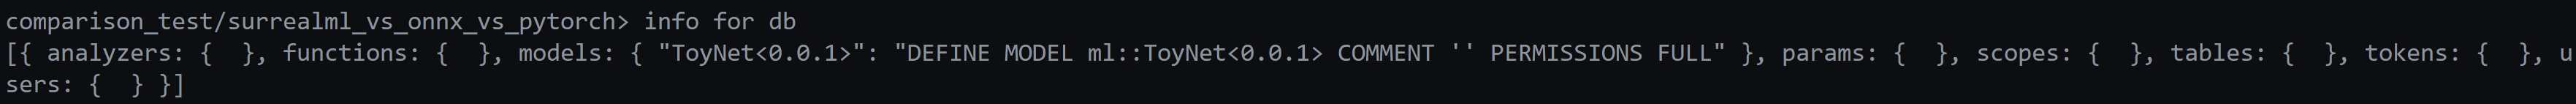

According to the documentation, the instance of the SurMlFile has an equivalent `.upload()` method that may be used to load the model in SurrealDB, check it [here](https://surrealdb.com/docs/surrealml#model-deployment).

<h2 id="7"></h2>

## Exporting the model to ONNX

We will subsequently export the model to ONNX, see the file `model.onnx` from the directory of the notebook. 

In [9]:
torch.onnx.export(
    model,
    example_input,
    "model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
)

<h2 id="8"></h2>

## Generating and inserting fake data into SurrealDB

We connect to SurrealDB and insert randomly generated test data in batches defined by max_number_inputs = $2^{16}$ inputs, split into batches of inputs batch_size = $2^{10}$.

**Back-of-the-envelope calculations**: Knowing that a datapoint is effectively a random float value, for a single precision machine, we have:

$$
4 \, \text{bytes per float (assunming single precision)} \times 10 \, \text{floats (the size of a single input for our model)} \times 2^{16} \approx 2.5 \, \text{MB}
$$


In case your machine supports less than this, or, on the contrary, you want to do more extensive benchmarking, adjust the values below accordingly.

In [10]:
max_number_inputs = 2**16  # adjust based on disk size
batch_size = 2**10  # adjust this according to RAM size
number_batches = max_number_inputs // batch_size

URL = "http://localhost:53333"
NS = "comparison_test"
DB = "surrealml_vs_onnx_vs_pytorch"

surreal = Surreal(
    url=URL,
    namespace=NS,
    database=DB,
    timeout=10**8,
)

Let us create the fake inputs of size 10 datapoints, coming in batches of $2^{10}$ inputs...

In [11]:
%%skip
with surreal.connect() as connect:
    for _ in range(number_batches):
        test_inputs = torch.rand(batch_size, 10).tolist()
        for test_input in test_inputs:
            # Construct the query to insert each element into separate feature columns
            query = f"""
            CREATE inputs:ulid()
            SET feature_1 = {test_input[0]},
                feature_2 = {test_input[1]},
                feature_3 = {test_input[2]},
                feature_4 = {test_input[3]},
                feature_5 = {test_input[4]},
                feature_6 = {test_input[5]},
                feature_7 = {test_input[6]},
                feature_8 = {test_input[7]},
                feature_9 = {test_input[8]},
                feature_10 = {test_input[9]},
                creation_time = time::now();
            """
            result = connect.query(query)

            if result.status == "OK":
                continue
            else:
                print(f"Failed to insert: {test_input}, Result: {result.result}")

<h2 id="9"></h2>

## Benchmarking SurrealML versus PyTorch versus ONNX

We are now going to define some functions which represent an `atomic prediction` in the 3 mentioned approaches of ML inference.

We start with the one for `SurrealML`...

In [12]:
@chronometer
def predict_with_surrealml(test_size, connect):
    query = f"""
    SELECT creation_time, ml::ToyNet<0.0.1>(
        {{
            feature_1: feature_1, 
            feature_2: feature_2, 
            feature_3: feature_3, 
            feature_4: feature_4, 
            feature_5: feature_5, 
            feature_6: feature_6, 
            feature_7: feature_7, 
            feature_8: feature_8, 
            feature_9: feature_9, 
            feature_10: feature_10
        }}
    )
    FROM inputs
    ORDER BY creation_time ASC
    LIMIT {test_size}
    """
    stringified_ml_query = "ml::ToyNet<0.0.1>({ feature_1: feature_1, feature_10: feature_10, feature_2: feature_2, feature_3: feature_3, feature_4: feature_4, feature_5: feature_5, feature_6: feature_6, feature_7: feature_7, feature_8: feature_8, feature_9: feature_9 })"
    result = connect.query(query)
    assert result.status == "OK"

    predictions = [
        prediction_with_features[stringified_ml_query]
        for prediction_with_features in result.result
    ]

    return predictions

Observe the `@chronometer` decorator, which will time the execution of the lines of code defined in its function.

In the same spirit, for PyTorch we have:

In [13]:
@chronometer
def predict_with_pytorch(test_size, connect):
    query = f"""
    SELECT 
        feature_1, feature_2, feature_3, feature_4, feature_5, 
        feature_6, feature_7, feature_8, feature_9, feature_10,
        creation_time
    FROM inputs
    ORDER BY creation_time ASC
    LIMIT {test_size}
    """
    result = connect.query(query)
    assert result.status == "OK"

    feature_order = [f"feature_{i}" for i in range(1, 11)]
    inputs_batch = [[d[feature] for feature in feature_order] for d in result.result]

    return model.forward(torch.tensor(inputs_batch)).flatten().tolist()

... and, respectively, to obtain predictions using the ONNX runtime directly, we define

In [14]:
@chronometer
def predict_with_onnx(test_size, connect):
    query = f"""
    SELECT 
        feature_1, feature_2, feature_3, feature_4, feature_5, 
        feature_6, feature_7, feature_8, feature_9, feature_10,
        creation_time
    FROM inputs
    ORDER BY creation_time ASC
    LIMIT {test_size}
    """
    result = connect.query(query)
    assert result.status == "OK"

    feature_order = [f"feature_{i}" for i in range(1, 11)]
    inputs_batch = np.array(
        [[d[feature] for feature in feature_order] for d in result.result]
    ).astype(np.float32)

    session = InferenceSession(f"./model.onnx")
    output = session.run(["output"], {"input": inputs_batch})

    return output[0].flatten().tolist()

Subsequently, let´s time the predictions in the 3 cases:

In [15]:
os.environ["ONNXRUNTIME_LIB_PATH"] = "/usr/local/lib"
os.environ["LD_LIBRARY_PATH"] = "/usr/local/lib:$LD_LIBRARY_PATH"

surreal_times = {}
pytorch_times = {}
onnx_times = {}
test_step = 2**3
number_steps = number_batches // test_step

try:
    with surreal.connect() as connect:
        for increment in range(number_steps):
            test_size = (increment + 1) * test_step
            print(f"RUN {increment} || NO inputs: " + str(test_size))
            print("#" * 100)
            print("\n")

            elapsed_time_surrealml, predictions_surrealml = predict_with_surrealml(
                test_size, connect
            )

            surreal_times[test_size] = elapsed_time_surrealml
            print(f"SurrealML: execution time took {elapsed_time_surrealml}s")
            print("#" * 100)
            print("\n")

            elapsed_time_onnx, predictions_onnx = predict_with_onnx(test_size, connect)
            onnx_times[test_size] = elapsed_time_onnx
            print(f"ONNX: execution time took {elapsed_time_onnx}s")
            print("#" * 100)
            print("\n")

            elapsed_time_pytorch, predictions_pytorch = predict_with_pytorch(
                test_size, connect
            )
            pytorch_times[test_size] = elapsed_time_pytorch
            print(f"PyTorch: execution time took {elapsed_time_pytorch}s")
            print("#" * 100)
            print("\n")

            if not torch.all(
                torch.isclose(
                    torch.tensor(predictions_surrealml),
                    torch.tensor(predictions_pytorch),
                )
            ):
                print("WARNING: Predictions from SurrealML and PyTorch differ!")
            else:
                print("Predictions from SurrealML and PyTorch do agree!")

            if not torch.all(
                torch.isclose(
                    torch.tensor(predictions_pytorch), torch.tensor(predictions_onnx),
                )
            ):
                print("WARNING: Predictions from PyTorch and ONNX differ!")
            else:
                print("Predictions from PyTorch and ONNX do agree!")

            # we break here after one iteration because of the performance bottleneck, see below:
            break
except Exception as e:
    print(e)

RUN 0 || NO inputs: 8
####################################################################################################


SurrealML: execution time took 268.3145275115967s
####################################################################################################


ONNX: execution time took 1.053638219833374s
####################################################################################################


PyTorch: execution time took 1.072693109512329s
####################################################################################################


Predictions from SurrealML and PyTorch do agree!
Predictions from PyTorch and ONNX do agree!


We decided to stop the tests after a single run, to inspect the results. Observe that executing with `SurrealML` took an unexpected amount of time, as compared to `ONNX` and `PyTorch`, which took a similar amount of time. This might be a possible `performance bottleneck`.

After experimenting for a while with other queries with SurrealML, I realized that the trouble comes when one uses the `ORDER BY` statement. Hence, let us skip it, but still check that the predictions for the 3 cases agree.

We redefine our benchmark functions:

In [16]:
@chronometer
def predict_with_surrealml(test_size, connect):
    query = f"""
    SELECT ml::ToyNet<0.0.1>(
        {{
            feature_1: feature_1, 
            feature_2: feature_2, 
            feature_3: feature_3, 
            feature_4: feature_4, 
            feature_5: feature_5, 
            feature_6: feature_6, 
            feature_7: feature_7, 
            feature_8: feature_8, 
            feature_9: feature_9, 
            feature_10: feature_10
        }}
    )
    FROM inputs
    LIMIT {test_size}
    """
    
    result = connect.query(query)
    assert result.status == "OK"

    predictions = result.result
    values = [list(prediction.values())[0] for prediction in predictions]

    return values

In [17]:
@chronometer
def predict_with_pytorch(test_size, connect):
    query = f"""
    SELECT 
        feature_1, feature_2, feature_3, feature_4, feature_5, 
        feature_6, feature_7, feature_8, feature_9, feature_10,
        creation_time
    FROM inputs
    LIMIT {test_size}
    """
    result = connect.query(query)
    assert result.status == "OK"

    feature_order = [f"feature_{i}" for i in range(1, 11)]
    inputs_batch = [[d[feature] for feature in feature_order] for d in result.result]

    return model.forward(torch.tensor(inputs_batch)).flatten().tolist()

In [18]:
@chronometer
def predict_with_onnx(test_size, connect):
    query = f"""
    SELECT 
        feature_1, feature_2, feature_3, feature_4, feature_5, 
        feature_6, feature_7, feature_8, feature_9, feature_10,
        creation_time
    FROM inputs
    LIMIT {test_size}
    """
    result = connect.query(query)
    assert result.status == "OK"

    feature_order = [f"feature_{i}" for i in range(1, 11)]
    inputs_batch = np.array(
        [[d[feature] for feature in feature_order] for d in result.result]
    ).astype(np.float32)

    session = InferenceSession(f"./model.onnx")
    output = session.run(["output"], {"input": inputs_batch})

    return output[0].flatten().tolist()

... and we redo the timing:

In [19]:
os.environ["ONNXRUNTIME_LIB_PATH"] = "/usr/local/lib"
os.environ["LD_LIBRARY_PATH"] = "/usr/local/lib:$LD_LIBRARY_PATH"

surreal_times = {}
pytorch_times = {}
onnx_times = {}
test_step = 2**3
number_steps = number_batches // test_step

try:
    with surreal.connect() as connect:
        for increment in range(number_steps):
            test_size = (increment + 1) * test_step
            print(f"RUN {increment} || NO inputs: " + str(test_size))
            print("#" * 100)
            print("\n")

            elapsed_time_surrealml, predictions_surrealml = predict_with_surrealml(
                test_size, connect
            )

            surreal_times[test_size] = elapsed_time_surrealml
            print(f"SurrealML: execution time took {elapsed_time_surrealml}s")
            print("#" * 100)
            print("\n")

            elapsed_time_onnx, predictions_onnx = predict_with_onnx(test_size, connect)
            onnx_times[test_size] = elapsed_time_onnx
            print(f"ONNX: execution time took {elapsed_time_onnx}s")
            print("#" * 100)
            print("\n")

            elapsed_time_pytorch, predictions_pytorch = predict_with_pytorch(
                test_size, connect
            )
            pytorch_times[test_size] = elapsed_time_pytorch
            print(f"PyTorch: execution time took {elapsed_time_pytorch}s")
            print("#" * 100)
            print("\n")

            if not torch.all(
                torch.isclose(
                    torch.tensor(predictions_surrealml),
                    torch.tensor(predictions_pytorch),
                )
            ):
                print("WARNING: Predictions from SurrealML and PyTorch differ!")
            else:
                print("Predictions from SurrealML and PyTorch do agree!")

            if not torch.all(
                torch.isclose(
                    torch.tensor(predictions_pytorch), torch.tensor(predictions_onnx),
                )
            ):
                print("WARNING: Predictions from PyTorch and ONNX differ!")
            else:
                print("Predictions from PyTorch and ONNX do agree!")
except Exception as e:
    print(e)

RUN 0 || NO inputs: 8
####################################################################################################


SurrealML: execution time took 0.027677297592163086s
####################################################################################################


ONNX: execution time took 0.007478475570678711s
####################################################################################################


PyTorch: execution time took 0.008169174194335938s
####################################################################################################


Predictions from SurrealML and PyTorch do agree!
Predictions from PyTorch and ONNX do agree!
RUN 1 || NO inputs: 16
####################################################################################################


SurrealML: execution time took 0.07466697692871094s
####################################################################################################


ONNX: execution time took 0.007027387619

Let us visualize the results:

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


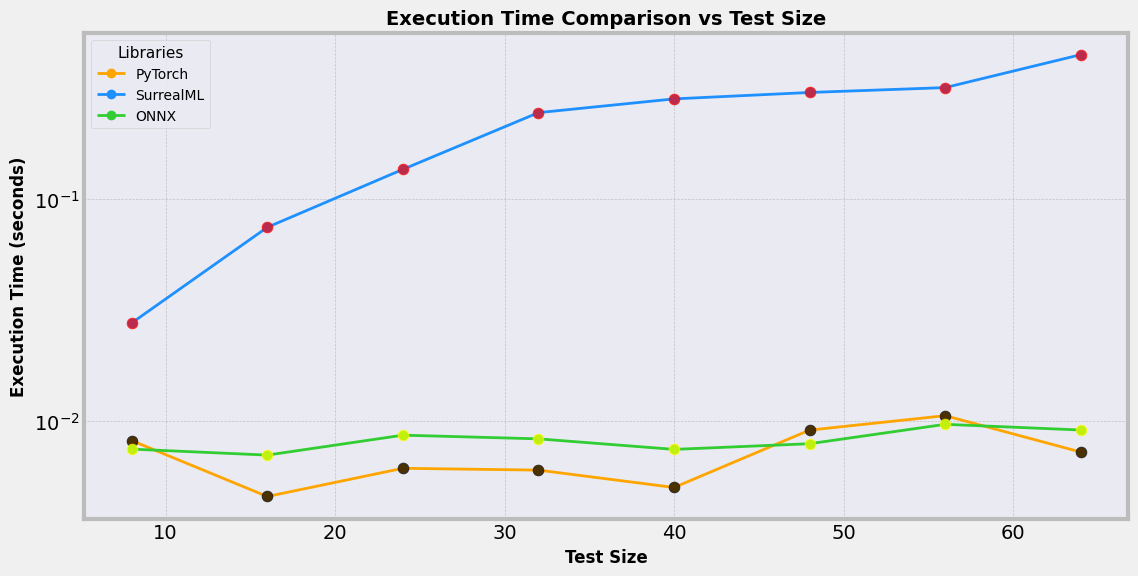

In [29]:
print(plt.style.available)
plt.style.use("bmh")
plt.rcParams["axes.facecolor"] = "#EAEAF2"
os.makedirs("./plots", exist_ok=True)

plt.figure(figsize=(12, 6))

plt.plot(
    pytorch_times.keys(),
    pytorch_times.values(),
    marker="o",
    color="#FFA500",
    markersize=6,
    linewidth=2,
    label="PyTorch",
)
sns.scatterplot(
    x=pytorch_times.keys(),
    y=pytorch_times.values(),
    s=60,
    color="black",
    alpha=0.7,
    edgecolor=None,
    zorder=2,
)

plt.plot(
    surreal_times.keys(),
    surreal_times.values(),
    marker="o",
    color="#1E90FF",
    markersize=6,
    linewidth=2,
    label="SurrealML",
)
sns.scatterplot(
    x=surreal_times.keys(),
    y=surreal_times.values(),
    s=60,
    color="red",
    alpha=0.7,
    edgecolor=None,
    zorder=2,
)

plt.plot(
    onnx_times.keys(),
    onnx_times.values(),
    marker="o",
    color="#32CD32",
    markersize=6,
    linewidth=2,
    label="ONNX",
)
sns.scatterplot(
    x=onnx_times.keys(),
    y=onnx_times.values(),
    s=60,
    color="yellow",
    alpha=0.7,
    edgecolor=None,
    zorder=2,
)

plt.xlabel("Test Size", fontsize=12, weight="bold")
plt.ylabel("Execution Time (seconds)", fontsize=12, weight="bold")
plt.title("SurrealML vs PyTorch vs ONNX", fontsize=14, weight="bold")
plt.yscale("log")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(title="Libraries", loc="upper left", fontsize=10, title_fontsize=11)

plot_path = os.path.join(os.getcwd(), "plots", "execution_time_vs_test_size.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()


`!!!` One should take note that the ONNX runtime used for SurrealML is strictly not the same one as the one used in `onnxscript`, see `set_onnx_runtime.sh` for more details about versions.

To conclude, `SurrealML` may be used to convert a PyTorch/ONNX model to the `.surml` format, and then infer with it inside SurrealDB.